In [ ]:
!pip install networkx
!pip install torch-geometric
!pip install node2vec

In [ ]:
import numpy as np
import pandas as pd
import random
import torch
import torch_geometric

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community as community_louvain
import torch.nn.functional as F


from torch import Tensor
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from scipy.stats import ttest_ind

print("Torch version:", torch.__version__)
print("Torch Geometric version:", torch_geometric.__version__)


Torch version: 2.6.0+cu124
Torch Geometric version: 2.6.1


In [ ]:
elliptic_txs_features = pd.read_csv("/content/elliptic_txs_features.csv", header=None)
elliptic_txs_classes  = pd.read_csv("/content/elliptic_txs_classes.csv")
elliptic_txs_edgelist = pd.read_csv("/content/elliptic_txs_edgelist.csv")

elliptic_txs_features.columns = ['txId'] + [f'V{i}' for i in range(1, 167)]

print(f"""Shapes
{4*' '}Features : {elliptic_txs_features.shape[0]:8,} (rows)  {elliptic_txs_features.shape[1]:4,} (cols)
{4*' '}Classes  : {elliptic_txs_classes.shape[0]:8,} (rows)  {elliptic_txs_classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {elliptic_txs_edgelist.shape[0]:8,} (rows)  {elliptic_txs_edgelist.shape[1]:4,} (cols)
""")

Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



In [ ]:
elliptic_txs_features.head(3)   # Dataset containing the node features.

,txId,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792


In [ ]:
elliptic_txs_classes.head(3)  # Dataset containing the classes of the node.

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown


In [ ]:
elliptic_txs_edgelist.head(3)  # Dataset containing the edges.

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870


In [ ]:
RANDOM_STATE = 42
NUM_EPOCHS = 100

elliptic_txs_classes['class_mapped'] = elliptic_txs_classes['class'].replace({'1': 'illicit', '2': 'licit'})

percentage_distribution = round(100 * elliptic_txs_classes['class_mapped'].value_counts(normalize=True), 2)
class_counts = elliptic_txs_classes['class_mapped'].value_counts()

emoji_mapping = {'licit': '✅', 'illicit': '❌', 'unknown': '🤷'}
elliptic_txs_classes['emoji'] = elliptic_txs_classes['class_mapped'].map(emoji_mapping)

classes_df = pd.DataFrame({
    'Class Mapped': elliptic_txs_classes['class_mapped'].unique(),
    'Class Raw': elliptic_txs_classes['class'].unique(),
    'Counts': class_counts.values,
    'Percentage': percentage_distribution.values,
    'Emoji': [emoji_mapping[class_label] for class_label in elliptic_txs_classes['class_mapped'].unique()]
})
classes_df

,Class Mapped,Class Raw,Counts,Percentage,Emoji
0,unknown,unknown,157205,77.15,🤷
1,licit,2,42019,20.62,✅
2,illicit,1,4545,2.23,❌


# **Graph Connectivity**

In [ ]:
# Create graph from the edgelist.
G = nx.from_pandas_edgelist(elliptic_txs_edgelist, 'txId1', 'txId2')

# Sampling for easier analysis...for now.
classes_sampled = elliptic_txs_classes.groupby('class_mapped').sample(frac=0.05, random_state=RANDOM_STATE)
txIds_sampled = classes_sampled['txId']

# Filter elliptic_txs_edgelist based on the sampled txIds
edgelist_sampled = elliptic_txs_edgelist[
    elliptic_txs_edgelist['txId1'].isin(txIds_sampled) | elliptic_txs_edgelist['txId2'].isin(txIds_sampled)
]

# Filter elliptic_txs_features based on the sampled txIds
features_sampled = elliptic_txs_features[elliptic_txs_features['txId'].isin(txIds_sampled)]

print(f"Sampled Classes:\n{classes_sampled['class_mapped'].value_counts()}\n")
print(f"Sampled Edgelist: {edgelist_sampled.shape[0]:,}")
print(f"Sampled Features: {features_sampled.shape[0]:,}")

Sampled Classes:
class_mapped
unknown    7860
licit      2101
illicit     227
Name: count, dtype: int64

Sampled Edgelist: 23,051
Sampled Features: 10,188


In [ ]:
# Create graph from the edgelist.
G = nx.from_pandas_edgelist(edgelist_sampled, 'txId1', 'txId2')

# --- Connected components ---
num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")

# --- Giant component analysis ---
giant_component = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(giant_component)

print(f"Giant component - Number of nodes: {G_giant.number_of_nodes():,}")
print(f"Giant component - Number of edges: {G_giant.number_of_edges():,}")

Number of connected components: 7297
Giant component - Number of nodes: 400
Giant component - Number of edges: 431


# **Graph Visualization**

In [ ]:
# Degree centrality.
degree_centrality = nx.degree_centrality(G_giant)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_degree_centrality = pd.DataFrame(top_degree_centrality, columns=['Node', 'Degree Centrality'])

print("Top 10 nodes by degree centrality:")
print("==================================")
print(df_top_degree_centrality)

top_nodes_by_ = df_top_degree_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)
node_color = [degree_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

Top 10 nodes by degree centrality:
        Node  Degree Centrality
0   22837965           0.275689
1   22837835           0.192982
2  279199578           0.030075
3    3807285           0.027569
4  279187194           0.027569
5   22837973           0.022556
6   90716926           0.022556
7    8128388           0.022556
8   22837808           0.020050
9   22838007           0.020050


In [ ]:
# Betweenness centrality.
betweenness_centrality = nx.betweenness_centrality(G_giant)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_betweenness_centrality = pd.DataFrame(top_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

print("Top 10 nodes by betweenness centrality:")
print("=======================================")
print(df_top_betweenness_centrality)

top_nodes_by_ = df_top_betweenness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)
node_color = [betweenness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

Top 10 nodes by betweenness centrality:
        Node  Betweenness Centrality
0   22837835                0.553959
1   22837965                0.491607
2   90716926                0.166458
3   22837784                0.165590
4  279187194                0.164591
5    3807285                0.144993
6    3097782                0.113509
7    8128388                0.103709
8    1435388                0.092219
9   21296808                0.086872


In [ ]:
# Closeness centrality.
closeness_centrality = nx.closeness_centrality(G_giant)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_closeness_centrality = pd.DataFrame(top_closeness_centrality, columns=['Node', 'Closeness Centrality'])

print("Top 10 nodes by closeness centrality:")
print("=====================================")
print(df_top_closeness_centrality)

top_nodes_by_closeness = df_top_closeness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_closeness)
node_color = [closeness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

Top 10 nodes by closeness centrality:
        Node  Closeness Centrality
0   22837835              0.317928
1   22837965              0.293814
2    2203811              0.290605
3    1805107              0.285817
4   11447640              0.285817
5    2205152              0.285817
6    1367537              0.285817
7    1437191              0.285817
8   21296808              0.274038
9  279187194              0.271613


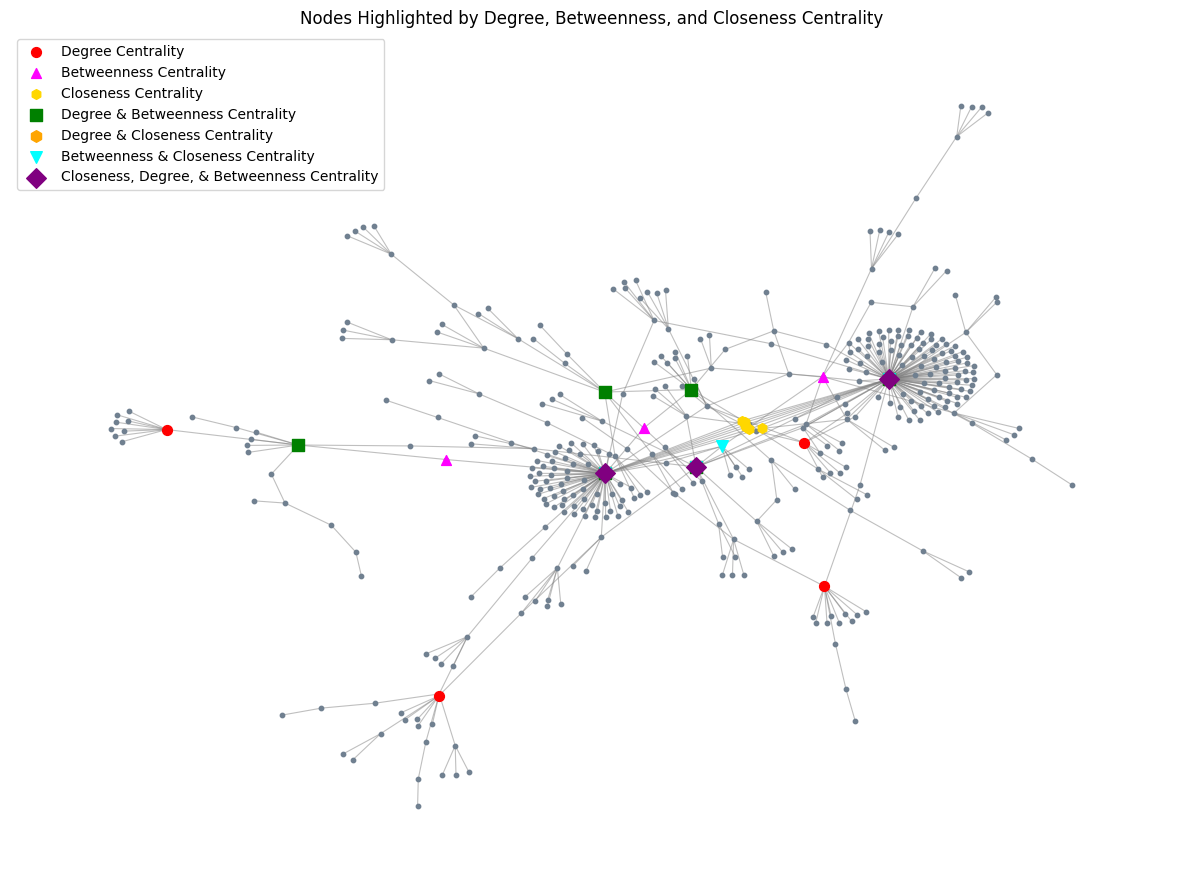

In [ ]:
# --------- #
# Preparing #
# --------- #

# Identify nodes that are top in each centrality measure and their combinations.
top_nodes_degree = set([node for node, _ in top_degree_centrality])
top_nodes_betweenness = set([node for node, _ in top_betweenness_centrality])
top_nodes_closeness = set([node for node, _ in top_closeness_centrality])

top_nodes_both = top_nodes_degree.intersection(top_nodes_betweenness)
top_nodes_closeness_and_degree = top_nodes_closeness.intersection(top_nodes_degree)
top_nodes_closeness_and_betweenness = top_nodes_closeness.intersection(top_nodes_betweenness)
top_nodes_all_three = top_nodes_closeness.intersection(top_nodes_degree).intersection(top_nodes_betweenness)

# Assign colors and shapes based on centrality measures.
node_color = []
node_shape = []

for node in G_giant.nodes():
    if node in top_nodes_all_three:
        node_color.append('purple')
        node_shape.append('D')
    elif node in top_nodes_closeness_and_degree:
        node_color.append('orange')
        node_shape.append('h')
    elif node in top_nodes_closeness_and_betweenness:
        node_color.append('cyan')
        node_shape.append('v')
    elif node in top_nodes_both:
        node_color.append('green')
        node_shape.append('s')
    elif node in top_nodes_degree:
        node_color.append('red')
        node_shape.append('o')
    elif node in top_nodes_betweenness:
        node_color.append('magenta')
        node_shape.append('^')
    elif node in top_nodes_closeness:
        node_color.append('yellow')
        node_shape.append('h')
    else:
        node_color.append('slategrey')
        node_shape.append('o')

# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(15, 11))

pos = nx.spring_layout(G_giant)
# Draw all nodes first.
nx.draw_networkx_nodes(G_giant, pos, node_color='slategrey', node_size=10)

# Draw nodes with specific centrality measures.
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_degree - top_nodes_both - top_nodes_closeness_and_degree),
                       node_color='red', node_size=50, node_shape='o',
                       label='Degree Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_betweenness - top_nodes_both - top_nodes_closeness_and_betweenness),
                       node_color='magenta', node_size=50, node_shape='^',
                       label='Betweenness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness - top_nodes_closeness_and_degree - top_nodes_closeness_and_betweenness),
                       node_color='gold', node_size=50, node_shape='h',
                       label='Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_both),
                       node_color='green', node_size=80, node_shape='s',
                       label='Degree & Betweenness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness_and_degree),
                       node_color='orange', node_size=70, node_shape='h',
                       label='Degree & Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness_and_betweenness),
                       node_color='cyan', node_size=70, node_shape='v',
                       label='Betweenness & Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_all_three),
                       node_color='purple', node_size=100, node_shape='D',
                       label='Closeness, Degree, & Betweenness Centrality')

# Draw edges.
nx.draw_networkx_edges(G_giant, pos, width=0.8, edge_color='gray', alpha=0.5)

plt.axis('off')
plt.title('Nodes Highlighted by Degree, Betweenness, and Closeness Centrality')
plt.legend(scatterpoints=1)
plt.show()


# **GNN**

Map txIds to indices (needed for graph). Filter only edges with known nodes. Create tensors for edges, features, and labels. Build Data object. Create masks so you can train and evaluate only on known-labeled nodes.

In [ ]:
num_edges = elliptic_txs_edgelist.shape[0]
num_nodes = elliptic_txs_features.shape[0]

print(f'Number of edges in the graph: {num_edges:8,}')
print(f'Number of nodes in the graph: {num_nodes:8,}')

Number of edges in the graph:  234,355
Number of nodes in the graph:  203,769


In [ ]:
# --------------------------------------------------------- #
# Create mapping with txId as key and actual index as value #
# --------------------------------------------------------- #

tx_id_mapping = {tx_id: idx for idx, tx_id in enumerate(elliptic_txs_features['txId'])}

edges_with_features = elliptic_txs_edgelist[elliptic_txs_edgelist['txId1'].isin(list(tx_id_mapping.keys()))\
                                          & elliptic_txs_edgelist['txId2'].isin(list(tx_id_mapping.keys()))].copy()

edges_with_features['Id1'] = edges_with_features['txId1'].map(tx_id_mapping)
edges_with_features['Id2'] = edges_with_features['txId2'].map(tx_id_mapping)

# Filter elliptic_txs_classes to include only txIds present in elliptic_txs_features
elliptic_txs_classes_filtered = elliptic_txs_classes[elliptic_txs_classes['txId'].isin(elliptic_txs_features['txId'])].copy()

edges_with_features

,txId1,txId2,Id1,Id2
0,230425980,5530458,0,1
1,232022460,232438397,2,3
2,230460314,230459870,4,5
3,230333930,230595899,6,7
4,232013274,232029206,8,9
...,...,...,...,...
234350,158365409,157930723,203602,201430
234351,188708874,188708879,203603,203099
234352,157659064,157659046,201921,202042
234353,87414554,106877725,201480,201368


In [ ]:
edge_index = torch.tensor(edges_with_features[['Id1', 'Id2']].values.T, dtype=torch.long)
edge_index

tensor([[     0,      2,      4,  ..., 201921, 201480, 201954],
        [     1,      3,      5,  ..., 202042, 201368, 201756]])

In [ ]:
# ------------------------------------- #
# Save node features in suitable format #
# ------------------------------------- #

node_features = torch.tensor(elliptic_txs_features.drop(columns=['txId']).values,
                             dtype=torch.float)
print(node_features.shape)
node_features

torch.Size([203769, 166])


tensor([[ 1.0000e+00, -1.7147e-01, -1.8467e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -1.7148e-01, -1.8467e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -1.7211e-01, -1.8467e-01,  ..., -1.8367e-01,
         -1.2061e-01, -1.1979e-01],
        ...,
        [ 4.9000e+01, -1.7201e-01, -7.8182e-02,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 4.9000e+01, -1.7284e-01, -1.7662e-01,  ..., -1.4060e-01,
          1.5197e+00,  1.5214e+00],
        [ 4.9000e+01, -1.2037e-02, -1.3228e-01,  ..., -1.4060e-01,
          1.5197e+00,  1.5214e+00]])

In [ ]:
elliptic_txs_classes['class'].value_counts()

,count
class,
unknown,157205
2,42019
1,4545


In [ ]:
# ------------------------ #
# Labelencode target class #
# ------------------------ #

le = LabelEncoder()
class_labels = le.fit_transform(elliptic_txs_classes_filtered['class'])
node_labels = torch.tensor(class_labels, dtype=torch.long)
original_labels = le.inverse_transform(class_labels)

print(original_labels)
print(class_labels)
print(node_labels)

['unknown' 'unknown' 'unknown' ... '1' 'unknown' 'unknown']
[2 2 2 ... 0 2 2]
tensor([2, 2, 2,  ..., 0, 2, 2])


In [ ]:
print(le.inverse_transform([0])) # illicit
print(le.inverse_transform([1])) # licit
print(le.inverse_transform([2])) # unknown

['1']
['2']
['unknown']


In [ ]:
# ------------------------------------ #
# Create pytorch geometric Data object #
# ------------------------------------ #

data = Data(x=node_features,
            edge_index=edge_index,
            y=node_labels)

In [ ]:
# Create masks based on the filtered classes
known_mask   = (data.y == 0) | (data.y == 1)  # Only nodes with known labels licit or illicit
unknown_mask = data.y == 2                    # Nodes with unknown labels


# ------------------------------------------------ #
# Define size for Training, Validation and Testing #
# ------------------------------------------------ #

num_known_nodes = known_mask.sum().item()
permutations = torch.randperm(num_known_nodes)
train_size = int(0.8 * num_known_nodes)
val_size = int(0.1 * num_known_nodes)
test_size = num_known_nodes - train_size - val_size

total = np.sum([train_size, val_size, test_size])

print(f"""Number of observations per split
    Training   : {train_size:10,} ({100*train_size/total:0.2f} %)
    Validation : {val_size:10,} ({100*val_size/total:0.2f} %)
    Testing    : {test_size:10,} ({100*test_size/total:0.2f} %)
""")

Number of observations per split
    Training   :     37,251 (80.00 %)
    Validation :      4,656 (10.00 %)
    Testing    :      4,657 (10.00 %)



In [ ]:
# ----------------------------------------------- #
# Create mask for the indices of Train, Val, Test #
# ----------------------------------------------- #

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

# Get the indices of the known nodes
known_indices = known_mask.nonzero(as_tuple=True)[0]

# Use the permutations on the known indices
train_indices = known_indices[permutations[:train_size]]
val_indices = known_indices[permutations[train_size:train_size + val_size]]
test_indices = known_indices[permutations[train_size + val_size:]]

data.train_mask[train_indices] = True
data.val_mask[val_indices] = True
data.test_mask[test_indices] = True

data.train_mask

tensor([False, False, False,  ...,  True, False, False])

In [ ]:
# ------------------------------------------- #
# Training, Evaluation and prediction methods #
# ------------------------------------------- #

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)

        correct = (pred[mask] == data.y[mask]).sum().item()
        accuracy = correct / mask.sum().item()

        y_true = data.y[mask].cpu().numpy()
        y_pred = pred[mask].cpu().numpy()

        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

    return metrics

def predict(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
    return pred

def predict_probabilities(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        probabilities = torch.exp(out)
    return probabilities


def train_gnn(num_epochs, data, model, optimizer, criterion):

    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    train_f1_scores = []

    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []

    # ----- #
    # Train #
    # ----- #

    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask],
                         data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # --- Calculate training metrics ---
        pred_train = out[data.train_mask].argmax(dim=1)
        correct_train = (pred_train == data.y[data.train_mask]).sum()
        train_acc = int(correct_train) / int(data.train_mask.sum())
        train_accuracies.append(train_acc)

        y_true_train = data.y[data.train_mask].cpu().numpy()
        y_pred_train = pred_train.cpu().numpy()

        train_prec = precision_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
        train_rec = recall_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
        train_f1 = f1_score(y_true_train, y_pred_train, average='weighted', zero_division=0)

        train_precisions.append(train_prec)
        train_recalls.append(train_rec)
        train_f1_scores.append(train_f1)
        train_losses.append(loss.item())

        # --- Validate and calculate validation metrics ---
        model.eval()
        with torch.no_grad():
            out = model(data)
            pred_val = out[data.val_mask].argmax(dim=1)
            correct_val = (pred_val == data.y[data.val_mask]).sum()
            val_acc = int(correct_val) / int(data.val_mask.sum())
            val_accuracies.append(val_acc)

            y_true_val = data.y[data.val_mask].cpu().numpy()
            y_pred_val = pred_val.cpu().numpy()

            val_prec = precision_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
            val_rec = recall_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
            val_f1 = f1_score(y_true_val, y_pred_val, average='weighted', zero_division=0)

            val_precisions.append(val_prec)
            val_recalls.append(val_rec)
            val_f1_scores.append(val_f1)

        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train - Acc: {train_acc:.4f} - Prec: {train_prec:.4f} - Rec: {train_rec:.4f} - F1: {train_f1:.4f}')
            print(f'                         Val   - Acc: {val_acc:.4f} - Prec: {val_prec:.4f} - Rec: {val_rec:.4f} - F1: {val_f1:.4f}')

    return {
        'train': {
            'losses': train_losses,
            'accuracies': train_accuracies,
            'precisions': train_precisions,
            'recalls': train_recalls,
            'f1_scores': train_f1_scores,
        },
        'val': {
            'accuracies': val_accuracies,
            'precisions': val_precisions,
            'recalls': val_recalls,
            'f1_scores': val_f1_scores,
        }
    }

def plot_train_val_test_metrics(train_val_metrics, test_metrics, num_epochs):
    plt.figure(figsize=(10, 6))

    # --- Accuracy ----
    plt.subplot(2, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_val_metrics['train']['accuracies'], color='C0', linewidth=1.0, label='Training')
    plt.plot(range(1, num_epochs + 1), train_val_metrics['val']['accuracies'], color='C1', linewidth=1.0, label='Validation', linestyle=':')
    plt.axhline(y=test_metrics['accuracy'], color='C2', linewidth=0.5, linestyle='--', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(fontsize=8)
    plt.title('Accuracy')

    # --- Precision ---
    plt.subplot(2, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_val_metrics['train']['precisions'], color='C0', linewidth=1.0, label='Training')
    plt.plot(range(1, num_epochs + 1), train_val_metrics['val']['precisions'], color='C1', linewidth=1.0, label='Validation', linestyle=':')
    plt.axhline(y=test_metrics['precision'], color='C2', linewidth=0.5, linestyle='--', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend(fontsize=8)
    plt.title('Precision')

    # --- Recall ---
    plt.subplot(2, 2, 3)
    plt.plot(range(1, num_epochs + 1), train_val_metrics['train']['recalls'], color='C0', linewidth=1.0, label='Training')
    plt.plot(range(1, num_epochs + 1), train_val_metrics['val']['recalls'], color='C1', linewidth=1.0, label='Validation', linestyle=':')
    plt.axhline(y=test_metrics['recall'], color='C2', linewidth=0.5, linestyle='--', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend(fontsize=8)
    plt.title('Recall')

    # --- F1-Score ---
    plt.subplot(2, 2, 4)
    plt.plot(range(1, num_epochs + 1), train_val_metrics['train']['f1_scores'], linewidth=1.0, color='C0', label='Training')
    plt.plot(range(1, num_epochs + 1), train_val_metrics['val']['f1_scores'], linewidth=1.0, color='C1', label='Validation', linestyle=':')
    plt.axhline(y=test_metrics['f1_score'], color='C2', linewidth=0.5, linestyle='--', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend(fontsize=8)
    plt.title('F1-Score')

    plt.tight_layout()
    plt.show()

In [ ]:
metrics_per_gnn = {
    'gcn': {
        'val': {
            'precisions': [],
            'probas': [],
        },
        'test': {
            'licit': {
                'probas': []
            },
            'illicit': {
                'probas': []
            },
        }
    },
    'gat': {
        'val': {
            'precisions': [],
            'probas': [],
        },
        'test': {
            'licit': {
                'probas': []
            },
            'illicit': {
                'probas': []
            },
        }
    },
    'gin': {
        'val': {
            'precisions': [],
            'probas': [],
        },
        'test': {
            'licit': {
                'probas': []
            },
            'illicit': {
                'probas': []
            },
        }
    }
}

In [ ]:

# -------------- #
# Define the GAT #
# -------------- #

class GAT(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, num_heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, 8, heads=num_heads, dropout=0.6)
        self.conv2 = GATConv(8 * num_heads, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# ---------- #
# Initialize #
# ---------- #

model = GAT(num_node_features=data.num_features, num_classes=len(le.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()  # Since we have a multiclass classification problem.

In [ ]:
# ----- #
# Train #
# ----- #

train_val_metrics = train_gnn(NUM_EPOCHS,
                              data,
                              model,
                              optimizer,
                              criterion)

metrics_per_gnn['gat']['val']['precisions'] = train_val_metrics['val']['precisions']

Epoch 010, Loss: 1.1262, Train - Acc: 0.8974 - Prec: 0.8554 - Rec: 0.8974 - F1: 0.8620
                         Val   - Acc: 0.9066 - Prec: 0.8759 - Rec: 0.9066 - F1: 0.8737
Epoch 020, Loss: 0.7087, Train - Acc: 0.8714 - Prec: 0.8676 - Rec: 0.8714 - F1: 0.8694
                         Val   - Acc: 0.8793 - Prec: 0.9018 - Rec: 0.8793 - F1: 0.8886
Epoch 030, Loss: 0.5430, Train - Acc: 0.9021 - Prec: 0.8745 - Rec: 0.9021 - F1: 0.8745
                         Val   - Acc: 0.9184 - Prec: 0.9054 - Rec: 0.9184 - F1: 0.9079
Epoch 040, Loss: 0.4599, Train - Acc: 0.9086 - Prec: 0.8895 - Rec: 0.9086 - F1: 0.8820
                         Val   - Acc: 0.9192 - Prec: 0.9083 - Rec: 0.9192 - F1: 0.8976
Epoch 050, Loss: 0.4213, Train - Acc: 0.9126 - Prec: 0.8959 - Rec: 0.9126 - F1: 0.8952
                         Val   - Acc: 0.9371 - Prec: 0.9323 - Rec: 0.9371 - F1: 0.9338
Epoch 060, Loss: 0.3902, Train - Acc: 0.9144 - Prec: 0.9022 - Rec: 0.9144 - F1: 0.8912
                         Val   - Acc: 0.937